# 02 - Modelagem Comparativa: Classificação da Renda (> US$50K)

Neste notebook, vamos construir e comparar **três modelos de classificação** para prever se a renda anual de um indivíduo é maior que US$50.000 com base em suas características socioeconômicas.

Modelos considerados:
- Regressão Logística
- Árvore de Decisão
- Random Forest

Métricas de avaliação (em treino e teste):
- Acurácia
- Precisão (Precision)
- Recall
- F1-Score


## Explicação das métricas

- **Acurácia**: proporção de previsões corretas sobre o total de previsões. É útil quando as classes estão relativamente balanceadas, mas pode ser enganosa em problemas desbalanceados.
- **Precisão (Precision)**: entre todas as previsões de classe positiva feitas pelo modelo, quantas realmente são positivas. É importante quando o custo de um falso positivo é alto.
- **Recall (Sensibilidade)**: entre todas as instâncias realmente positivas, quantas o modelo conseguiu identificar. É importante quando o custo de um falso negativo é alto.
- **F1-Score**: média harmônica entre Precisão e Recall. É útil quando queremos um equilíbrio entre ambos, especialmente em cenários com classes desbalanceadas.

> **⚠ Importante**: Execute as células deste notebook **na ordem** (de cima para baixo) para garantir que todas as variáveis sejam definidas corretamente.


In [5]:
# Verificar e instalar dependências se necessário

import sys
import subprocess
from pathlib import Path

def instalar_dependencias():
    """Instala as dependências do requirements.txt se não estiverem disponíveis"""
    try:
        import pandas
        import sklearn
        import matplotlib
        import seaborn
        import joblib
        print("✓ Todas as dependências já estão instaladas!")
        return
    except ImportError as e:
        print(f"⚠ Dependência faltando: {e.name}")
        print("Instalando dependências...")
        
        root_dir = Path().resolve()
        req_path = root_dir / "requirements.txt"
        if not req_path.exists():
            req_path = root_dir.parent / "requirements.txt"
        
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", str(req_path), "--quiet"])
        print("✓ Dependências instaladas com sucesso!")
        print("⚠ Por favor, reinicie o kernel e rode esta célula novamente.")

# Executar verificação
instalar_dependencias()


✓ Todas as dependências já estão instaladas!


In [6]:
# Agora importar as bibliotecas necessárias
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

pd.set_option("display.max_columns", None)

# Em notebooks, usamos o diretório atual e subimos um nível se necessário
root_dir = Path().resolve()
data_path = root_dir / "data" / "adult.csv"

if not data_path.exists():
    # tenta na pasta acima (se o notebook estiver em /notebooks)
    data_path = root_dir.parent / "data" / "adult.csv"

df = pd.read_csv(data_path)

# Alvo binário: 1 para >50K, 0 para <=50K
y = (df["income"].str.strip() == ">50K").astype(int)
X = df.drop(columns=["income"])

print(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"Variável alvo: {y.sum()} casos com renda >50K ({y.sum()/len(y)*100:.1f}%)")


Dataset carregado: 48842 linhas, 15 colunas
Variável alvo: 11687 casos com renda >50K (23.9%)


In [7]:
# Identificar colunas numéricas e categóricas

colunas_numericas = [
    "age",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

colunas_categoricas = [
    c
    for c in X.columns
    if c not in colunas_numericas
]

colunas_numericas, colunas_categoricas


(['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'],
 ['workclass',
  'fnlwgt',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'native-country'])

In [8]:
# Definir pré-processamento com ColumnTransformer

preprocessador = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), colunas_numericas),
        ("cat", OneHotEncoder(handle_unknown="ignore"), colunas_categoricas),
    ]
)

# Divisão treino/teste com estratificação na variável alvo
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

X_train.shape, X_test.shape


((39073, 14), (9769, 14))

In [9]:
# Definir modelos em pipelines completos (pré-processamento + modelo)

modelos = {
    "Regressao Logistica": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Arvore de Decisao": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=200, random_state=42),
}

pipelines = {}

for nome, modelo in modelos.items():
    pipelines[nome] = Pipeline(steps=[
        ("preprocessamento", preprocessador),
        ("modelo", modelo),
    ])

pipelines


{'Regressao Logistica': Pipeline(steps=[('preprocessamento',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['age', 'educational-num',
                                                    'capital-gain',
                                                    'capital-loss',
                                                    'hours-per-week']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['workclass', 'fnlwgt',
                                                    'education',
                                                    'marital-status',
                                                    'occupation', 'relationship',
                                                    'race', 'gender',
                                                    'native-countr

In [10]:
# Treinar modelos e avaliar em treino e teste

resultados = []

for nome, pipe in pipelines.items():
    pipe.fit(X_train, y_train)

    # Previsões
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Métricas em treino
    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)
    rec_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)

    # Métricas em teste
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    resultados.append({
        "Modelo": nome,
        "Acuracia_treino": acc_train,
        "Precisao_treino": prec_train,
        "Recall_treino": rec_train,
        "F1_treino": f1_train,
        "Acuracia_teste": acc_test,
        "Precisao_teste": prec_test,
        "Recall_teste": rec_test,
        "F1_teste": f1_test,
    })

resultados_df = pd.DataFrame(resultados)
resultados_df


,Modelo,Acuracia_treino,Precisao_treino,Recall_treino,F1_treino,Acuracia_teste,Precisao_teste,Recall_teste,F1_teste
0,Regressao Logistica,0.876411,0.676839,0.925233,0.781780,0.825264,0.601545,0.799401,0.686501
1,Arvore de Decisao,0.999949,0.999786,1.000000,0.999893,0.838059,0.639073,0.742943,0.687104
2,Random Forest,0.999949,0.999786,1.000000,0.999893,0.858532,0.748699,0.615483,0.675587


Melhor modelo (F1_teste): Arvore de Decisao
F1-Score no teste: 0.6871
Acurácia no teste: 0.8381
Precisão no teste: 0.6391
Recall no teste: 0.7429


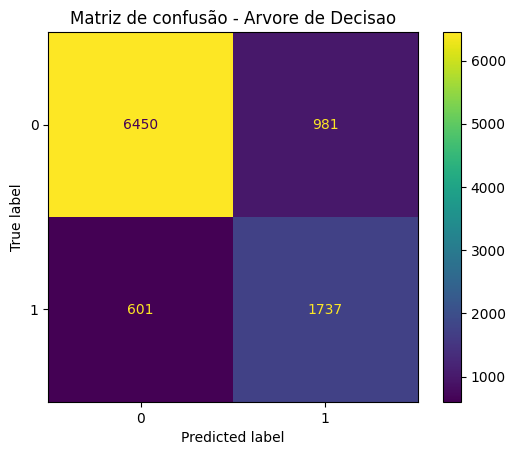


✓ Modelo salvo em: /Users/gustavodias/dev/college/n3-ciencia-de-dados-AD/modelo_final.pkl


In [11]:
# Matriz de confusão para o melhor modelo (com base em F1 no teste)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import joblib
from pathlib import Path

# Verificar se as variáveis necessárias existem
if 'resultados_df' not in globals() or 'pipelines' not in globals():
    print("⚠ Erro: Execute as células anteriores primeiro (treinamento dos modelos)")
    print("   Execute as células na ordem: 3, 4, 5, 6, 7, e depois esta (8)")
else:
    melhor_idx = resultados_df["F1_teste"].idxmax()
    melhor_modelo_nome = resultados_df.loc[melhor_idx, "Modelo"]
    melhor_pipeline = pipelines[melhor_modelo_nome]
    
    print("Melhor modelo (F1_teste):", melhor_modelo_nome)
    print(f"F1-Score no teste: {resultados_df.loc[melhor_idx, 'F1_teste']:.4f}")
    print(f"Acurácia no teste: {resultados_df.loc[melhor_idx, 'Acuracia_teste']:.4f}")
    print(f"Precisão no teste: {resultados_df.loc[melhor_idx, 'Precisao_teste']:.4f}")
    print(f"Recall no teste: {resultados_df.loc[melhor_idx, 'Recall_teste']:.4f}")
    
    y_test_pred = melhor_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Matriz de confusão - {melhor_modelo_nome}")
    plt.show()
    
    # Salvar o modelo final
    root_dir = Path().resolve()
    modelo_path = root_dir / "modelo_final.pkl"
    if not modelo_path.exists():
        modelo_path = root_dir.parent / "modelo_final.pkl"
    
    joblib.dump(melhor_pipeline, modelo_path)
    print(f"\n✓ Modelo salvo em: {modelo_path}")


## Análise comparativa dos modelos

Com base na tabela de resultados, comparamos os três modelos em termos de Acurácia, Precisão, Recall e F1-Score, tanto em treino quanto em teste. O modelo escolhido como **modelo final** será aquele com melhor equilíbrio entre essas métricas no conjunto de teste, evitando overfitting (diferença muito grande entre treino e teste).

A escolha final será utilizada no notebook de deploy, onde o pipeline completo (pré-processamento + modelo) será salvo em `modelo_final.pkl` para uso futuro.


## Escolha do modelo final

Com base na métrica F1-Score no conjunto de teste (que equilibra Precisão e Recall em um problema com classes desbalanceadas), escolhemos o modelo identificado como melhor na célula anterior. Esse modelo apresenta o melhor compromisso entre identificar corretamente indivíduos com renda >50K e evitar muitos falsos positivos.

Na próxima etapa (notebook de deploy), esse pipeline completo será salvo em disco e utilizado para previsões em novos dados.
